## prove xgboost can overfit this problem

## prove simple nn can overfit this problem

### The conclusion of this experiment is that the embeddings from the pretrained model significantly distinguish differences


In [77]:
import os
import torch

In [78]:
image_folder_path = (
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data/full_image"
)
image_name_list = os.listdir(image_folder_path)
image_name_list.sort()
image_name_list = [
    image_name for image_name in image_name_list if not image_name.startswith(".")
]
image_path_list = [
    os.path.join(image_folder_path, image_name) for image_name in image_name_list
]

In [79]:
import pandas as pd

data_path = (
    "/Users/user/Documents/Coding/cro_location_intelligence/notebook/7 BE for Ford.xlsx"
)
df_dict = pd.read_excel(data_path, sheet_name=None)
store_id_list = df_dict["Train"]["store_id"].tolist()
store_id_list += df_dict["Test2022"]["store_id"].tolist()
store_id_list = [str(i) for i in store_id_list]
print(len(store_id_list))
print(store_id_list[:5])

1066
['1025', '8396', '8572', '1058', '1095']


In [80]:
store_id_we_have = []
for image_name in image_name_list:
    store_id_we_have.append(image_name.split(".")[0])
print(len(store_id_we_have))
print(store_id_we_have[:5])

9997
['10', '100', '1000', '10000', '10001']


In [81]:
store_id_we_dont_have = []
for id in store_id_list:
    if id not in store_id_we_have:
        print(id)
        store_id_we_dont_have.append(id)

print(len(store_id_we_dont_have))

4926
5350
5651
6034
6298
9143
9295
9364
9381
9385
9454
11022
11185
11397
11413
12007
13099
13218
13947
14422
17542
21


In [82]:
len(store_id_list)

1066

In [83]:
# feed model net
from urllib.request import urlopen
from PIL import Image
import timm
from tqdm import tqdm

# new_df_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/7 lat long with embedding.csv"
new_df_path = "/Users/user/Documents/Coding/cro_location_intelligence/src/data/all_data_embedding.csv"
if not os.path.exists(new_df_path):
    # img = Image.open(urlopen(
    #     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
    # ))
    # img = image_1
    output_dict = {}
    model = timm.create_model(
        "maxvit_tiny_tf_512.in1k",
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)

    # for image_name in image_name_list:
    batch_size = 4
    # check is file exist

    check_store_id_list = []
    for store_id in store_id_list:
        image_name = store_id + ".png"
        image_path = os.path.join(image_folder_path, image_name)
        if os.path.exists(image_path):
            check_store_id_list.append(store_id)
    store_id_list = check_store_id_list
    print("len(store_id_list)", len(store_id_list))
    # Iterate through store_ids in batches
    for batch_start in tqdm(
        range(0, len(store_id_list), batch_size), desc="store_id batches"
    ):
        batch_store_ids = store_id_list[batch_start : batch_start + batch_size]
        batch_images = []

        # Load and preprocess images in the current batch
        for store_id in batch_store_ids:
            image_name = store_id + ".png"
            image_path = os.path.join(image_folder_path, image_name)
            img = Image.open(image_path).convert("RGB")
            batch_images.append(transforms(img))

        # Stack images to create a batch
        batch_images = torch.stack(batch_images)

        # Forward pass for the batch
        with torch.no_grad():
            output = model.forward_features(batch_images)
            output = model.forward_head(output, pre_logits=True)

        # Store results in output_dict
        for i, store_id in enumerate(batch_store_ids):
            output_dict[store_id] = output.detach().numpy()[i]
        # output is a (1, num_features) shaped tensor

In [84]:
import numpy as np

r = 2
circle_area = np.pi * r**2
square_area = (2 * r) ** 2
circle_area, square_area, circle_area / square_area

(12.566370614359172, 16, 0.7853981633974483)

In [85]:
# rename columns by add prefix "embedding_"

In [86]:
# merge 2 df by index
import pandas as pd

# convert output_dict to dataframe
if os.path.exists(new_df_path) is False:
    output_df = pd.DataFrame.from_dict(output_dict, orient="index")
    output_df.head()
    output_df.columns = ["embedding_" + str(col + 1) for col in output_df.columns]
    # convert output_df store_id to int
    output_df["store_id"] = output_df.index
    output_df.store_id = output_df.store_id.astype(int)
    data_path = (
        "/Users/user/Documents/Coding/cro_location_intelligence/src/data/all_data.csv"
    )
    df = pd.read_csv(data_path)
    # merge df with output_df with columns store_id
    df = pd.merge(df, output_df, on="store_id", how="inner")

    # df = pd.concat([df, output_df], axis=1)
    df.to_csv(new_df_path, index=False)
else:
    df = pd.read_csv(new_df_path)
    df.head()

In [116]:
# use embedding to predict mockup_sale with xgboost
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# get all column has embedding_ prefix
feature_columns = [col for col in df.columns if col.startswith("embedding_")]
feature_columns += ["subset"]
feature_columns += ["y_nor"]
# assign to x
# all_data = df[feature_columns]
all_data = df.copy()

In [120]:
# all_data.columns.tolist()

In [88]:
# normalize every column
from sklearn.preprocessing import StandardScaler

all_data = all_data.drop(columns=["store_id"])
all_data = all_data.drop(columns=["y_nor"])
train_all_data = all_data[all_data.subset == "train"]
all_data = all_data.drop(columns=["subset"])
train_all_data = train_all_data.drop(columns=["subset"])
scaler = StandardScaler()
scaler.fit(train_all_data)
all_data = scaler.transform(all_data)
all_data = pd.DataFrame(all_data)
# all_data.columns = feature_columns
# all_data["store_id"] = df["store_id"]
all_data["y_nor"] = df["y_nor"]
all_data["subset"] = df["subset"]
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,886,887,888,889,890,891,892,893,y_nor,subset
0,0.809053,-0.435626,1.276019,-0.585552,1.119992,-0.60246,1.958702,1.316572,-0.099400,1.694327,...,0.457054,-0.610891,-0.983325,-0.104843,-0.690702,0.676902,-0.050310,-0.970355,0.226238,train
1,0.587070,-0.246327,-0.271598,-0.585552,0.117934,-0.60246,-0.168104,-0.166140,0.836214,1.078724,...,0.214278,0.107851,-0.604111,1.191268,-0.142626,-0.891032,-1.833997,-1.052687,0.182798,train
2,0.734251,-0.290767,-0.193664,-0.585552,-1.067295,-0.60246,-1.462083,-0.616988,0.513588,-0.768087,...,0.111415,0.517898,1.058781,0.610704,0.993412,0.783935,-2.070301,0.448145,0.433002,train
3,-0.999912,-0.399375,0.070823,-0.585552,-0.185915,-0.60246,-1.505405,-1.400555,-1.083407,0.463120,...,1.090279,-0.993677,-1.624377,-2.052572,-1.662305,-0.279813,2.566342,0.782599,0.221966,train
4,0.755420,-0.386677,0.213359,-0.585552,0.219217,-0.60246,-0.560023,-1.109370,-1.076954,0.463120,...,-0.251072,0.919632,1.697689,0.254650,-0.923269,-0.959682,-2.228328,-0.127967,0.149573,train


In [89]:
# create train test with columns subset
x_train = all_data[all_data.subset == "train"]
x_train = x_train.drop(columns=["subset"])
y_train = x_train["y_nor"]
x_test = all_data[all_data.subset == "test"]
x_test = x_test.drop(columns=["subset"])
y_test = x_test["y_nor"]
x_train = x_train.drop(columns=["y_nor"])
x_test = x_test.drop(columns=["y_nor"])

In [90]:
x_train.shape, y_train.shape

((977, 894), (977,))

In [91]:
import matplotlib.pyplot as plt

mean_absolute_percentage_error: 1.271153142742062


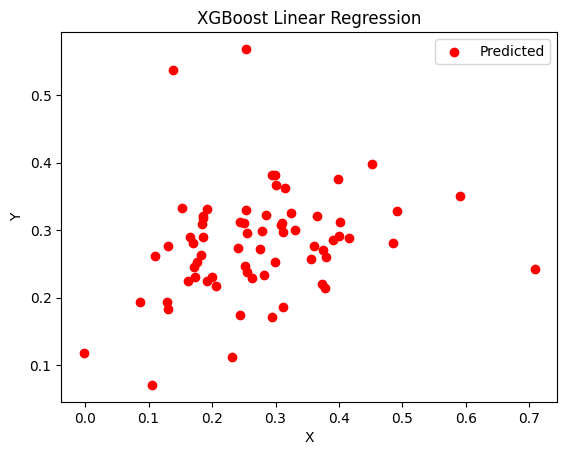

In [92]:
# Create an XGBoost regressor
regressor = xgb.XGBRegressor(objective="reg:squarederror", seed=42)

# Train the model
regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(x_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"mean_absolute_percentage_error: {mape}")

# Plot the results
# plt.scatter(x_test, y_test, color="black", label="Actual")
plt.scatter(y_test, y_pred, color="red", label="Predicted")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("XGBoost Linear Regression")
plt.legend()
plt.show()

In [93]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print(
            "MPS not available because the current PyTorch install was not "
            "built with MPS enabled."
        )
    else:
        print(
            "MPS not available because the current MacOS version is not 12.3+ "
            "and/or you do not have an MPS-enabled device on this machine."
        )
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using mps device


In [94]:
X_train = np.array(x_train)
X_test = np.array(x_test)

# create validate set
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

(array([ 3.,  0.,  3.,  1.,  8.,  3.,  7.,  7., 15.,  9., 18., 20., 18.,
        22., 23., 28., 37., 29., 21., 29., 19., 27., 25., 28., 25., 28.,
        19., 18., 16., 15., 12., 11., 18., 13., 15., 10.,  7., 10.,  8.,
         8.,  6.,  6.,  2.,  3.,  4.,  2.,  1.,  5.,  3.,  0.,  3.,  1.,
         1.,  0.,  0.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

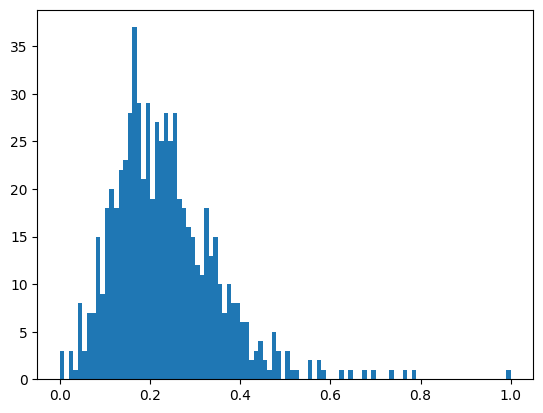

In [95]:
# plot histogram y_train and y_val
import matplotlib.pyplot as plt

plt.hist(y_train, bins=100)

(array([ 1.,  0.,  0.,  1.,  2.,  1.,  2.,  0.,  4.,  1.,  1.,  5.,  3.,
         4.,  5.,  6.,  5.,  5.,  8.,  5.,  5., 10.,  0.,  4., 15., 10.,
        10.,  4.,  7.,  8., 12.,  3.,  6.,  4.,  5.,  7.,  6.,  7., 13.,
         6.,  8.,  2.,  4.,  4.,  3.,  3.,  5.,  5.,  3.,  4.,  5.,  2.,
         4.,  4.,  3.,  5.,  2.,  2.,  2.,  3.,  3.,  0.,  2.,  0.,  4.,
         1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01056808, 0.01714187, 0.02371567, 0.03028946, 0.03686326,
        0.04343705, 0.05001085, 0.05658464, 0.06315844, 0.06973223,
        0.07630603, 0.08287982, 0.08945361, 0.09602741, 0.1026012 ,
        0.109175  , 0.11574879, 0.12232259, 0.12889638, 0.13547018,
        0.14204397, 0.14861777, 0.15519156, 0.16176535, 0.16833915,
        0.17491294, 0.18148674, 0.18806053, 0.19463433, 0.20120812,
        0.20778192, 0.2143

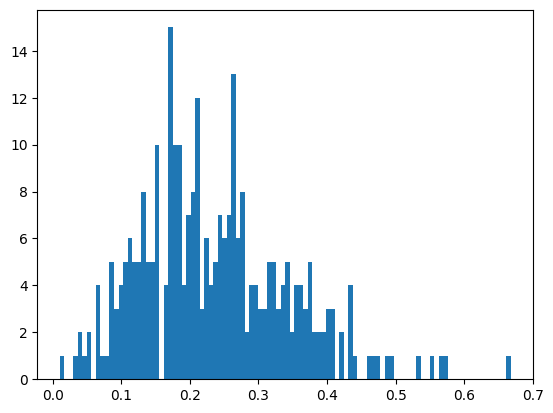

In [96]:
# plot histogram  y_val
import matplotlib.pyplot as plt

plt.hist(y_val, bins=100)

In [97]:
import torch.nn as nn

In [98]:
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import lightning as pl
from torch.nn import Dropout, BatchNorm1d
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

from lightning.pytorch.loggers import TensorBoardLogger
from torch.nn import Linear, BatchNorm1d, Dropout


class MAPELoss(nn.Module):
    def forward(self, y_pred, y_true):
        epsilon = 1e-7
        percentage_error = torch.abs((y_true - y_pred) / (y_true + epsilon))
        mape = torch.mean(percentage_error) * 100.0
        return mape


# Define a simple dataset
class PriceDataset(Dataset):
    def __init__(self, features, labels, transform_y=None, transform_x=None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.transform_y = transform_y
        self.transform_x = transform_x

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        if self.transform_x:
            x = self.transform_x(x)
        if self.transform_y:
            y = self.transform_y(y)
        return x, y


class PricePredictor(pl.LightningModule):
    def __init__(
        self,
        input_size,
        layer_sizes=[],
        dropout_rate=0.7,
        last_layer_dropout_rate=0.1,
        momentum=0.1,
        use_batch_norm=True,
        lr=0.00001,
    ):
        super(PricePredictor, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        self.use_batch_norm = use_batch_norm
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()  # Use BatchNorm1d instead of LayerNorm
        self.dropouts = nn.ModuleList()

        for i in range(1, len(layer_sizes)):
            self.layers.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))

            self.batch_norms.append(nn.BatchNorm1d(layer_sizes[i], momentum=momentum))

            # Use last_layer_dropout_rate for the last layer, otherwise use dropout_rate
            if i == len(layer_sizes) - 1:
                self.dropouts.append(nn.Dropout(p=last_layer_dropout_rate))
            else:
                self.dropouts.append(nn.Dropout(p=dropout_rate))

        self.lr = lr
        self.val_loss = 0
        self.training_step_loss = []

    def forward(self, x):
        for i in range(len(self.layers)):
            if self.use_batch_norm:
                # Use BatchNorm1d instead of LayerNorm
                x = F.leaky_relu(self.batch_norms[i](self.layers[i](x)))
            else:
                x = F.leaky_relu(self.layers[i](x))

            x = self.dropouts[i](x)

        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.training_step_loss.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.val_loss = loss
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.log("test_loss", loss)

    def on_train_epoch_end(self):
        # print("\n\tself.training_step_loss", self.training_step_loss)
        # print("\n\tself.training_step_loss", self.training_step_loss[0].shape)
        # print("\n\tself.training_step_loss", self.training_step_loss[0])
        # print()
        # avg_loss = torch.stack([x["loss"] for x in self.training_step_loss]).mean()
        avg_loss = torch.stack(
            [x.detach().cpu() for x in self.training_step_loss]
        ).mean()
        self.log("train_loss", avg_loss.item(), on_epoch=True)


from lightning.pytorch.callbacks import LearningRateFinder


class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones
        self._min_lr = 1e-6
        self._max_lr = 1e-1
        # self._num_training_steps = 1000
        self._mode = "linear"

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)


from lightning.pytorch.callbacks.early_stopping import EarlyStopping

np.random.seed(42)


class AddNoise(object):
    def __init__(self, noise_level=0.01):
        self.noise_level = noise_level

    def __call__(self, x):
        # random apply 20% of the time
        if torch.rand(1) < 0.2:
            return x
        noise = torch.randn_like(x) * self.noise_level
        augmented_x = x + noise
        return augmented_x


transforms_x = AddNoise(noise_level=0.1)
transforms_y = AddNoise(noise_level=0.025)
# batch_size = 32
batch_size = 256

num_workers = 0
train_dataset = PriceDataset(
    X_train, y_train, transform_x=transforms_x, transform_y=transforms_y
)
test_dataset = PriceDataset(X_test, y_test)
val_dataset = PriceDataset(X_val, y_val)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
from lightning.pytorch.callbacks import ModelCheckpoint

# dir_path = os.path.dirname(os.path.realpath(__file__))
dir_path = ""
checkpoint_callback = ModelCheckpoint(
    dirpath=f"{dir_path}/models/",
    save_top_k=2,
    monitor="val_loss",
    filename="best_model-{epoch}",
)

# Initialize the model
input_size = X_train.shape[1:]
model = PricePredictor(input_size[0], layer_sizes=[512, 128, 32, 1]).to(device)
# check_point_path = "/Users/user/Documents/Coding/cro_location_intelligence/src/models/pretrain.ckpt"
# model.load_from_checkpoint(check_point_path)
# model = PricePredictor.load_from_checkpoint(
#     check_point_path,
#     input_size=input_size[0],
#     layer_sizes=[512, 128, 32, 1],
#     use_batch_norm=False,
#     dropout_rate=0.2,
# ).to(device)

# model.eval()
# Initialize a PyTorch Lightning Trainer
logger = TensorBoardLogger(f"{dir_path}/tb_logs", name="my_model")

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=50, verbose=False, mode="min"
)
trainer = pl.Trainer(
    callbacks=[
        FineTuneLearningRateFinder(
            milestones=(
                100,
                1000,
                2000,
                3000,
                5000,
                10000,
            )
        ),
        early_stop_callback,
        checkpoint_callback,
    ],
    min_epochs=20000,
    max_epochs=30000,
    logger=logger,
    precision="16-mixed",
    accelerator="mps",
)
# Train the model
# trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# # Test the model
# trainer.test(dataloaders=test_loader)

# # Make predictionss
# model.to(device)
# model.eval()
# with torch.no_grad():
#     example_input = torch.tensor(X_test[:5], dtype=torch.float32).to(device)
#     predictions = model(example_input).flatten().cpu().numpy()

# print("Example Predictions:", predictions)

Using 16bit Automatic Mixed Precision (AMP)


/Users/user/miniconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


894

In [99]:
trainer.checkpoint_callback

In [100]:
# for i, (path, _) in enumerate(trainer.checkpoint_callback.best_k_models.items()):
for i, path in enumerate(
    # ["/Users/user/Documents/Coding/cro_location_intelligence/src/models/test.ckpt"]
    [
        "/Users/user/Documents/Coding/cro_location_intelligence/src/models/test.ckpt"
        # "/Users/user/Documents/Coding/cro_location_intelligence/src/models_transfer/test.ckpt"
    ]
):
    model = PricePredictor.load_from_checkpoint(
        path, input_size=input_size[0], layer_sizes=[512, 128, 32, 1]
    )
    PATH = f"./models/{i}th_best.pt"
    torch.save(model, PATH)

In [101]:
# torch.save(model.state_dict(), PATH)

In [102]:
model.device

device(type='mps', index=0)

In [103]:
# checkpoint_path = "/Users/user/Documents/Coding/cro_location_intelligence/src/models_version34/best_model-epoch=353.ckpt"
# # model = PricePredictor.load_from_checkpoint(
# #     checkpoint_path=checkpoint_path,
# #     input_size=input_size[0],
# #     use_mps_device=True,
# # )
# model = torch.load(checkpoint_path)

# model.eval()
# model.to("mps")

In [104]:
model.to(device)
model.eval()
number_predict = 100
with torch.no_grad():
    example_input = torch.tensor(X_test[:number_predict], dtype=torch.float32).to("mps")
    predictions = model(example_input).flatten().cpu().numpy()
    # predictions = [int(round(pred)) for pred in predictions]

print("Example Predictions:", predictions)
print("Ground Truth:", y_test[:number_predict])

Example Predictions: [ 2.9295850e-01  3.8961300e-01  2.7650017e-01  2.6938891e-01
  2.7312839e-01  2.2378471e-01  2.8540173e-01  2.7703723e-01
 -4.4739367e-03  2.3621581e-01  2.0524192e-01  2.2097272e-01
  2.6329130e-01  2.0864370e-01  2.9372030e-01  2.8378612e-01
  2.3546000e-01  1.6270493e-01  2.0218994e-01  3.2783219e-01
  2.4154061e-01  2.9017505e-01  2.6919127e-01  2.9491788e-01
  2.3792371e-01  3.0946428e-01 -2.4650409e-03  2.6618516e-01
 -1.1878837e-04  2.6195994e-01  2.4793027e-01  2.7193409e-01
  3.0000612e-01  3.5042667e-01  3.1272328e-01  3.3440170e-01
  2.6494384e-01  2.5933108e-01  2.2944178e-01  2.3154210e-01
  2.2494982e-01  2.0120400e-01  2.4966867e-01  4.8092920e-01
  2.6645929e-01  2.6819894e-01 -1.5820084e-04  1.7597906e-01
  1.3353324e-01  1.7709695e-01  2.5696692e-01 -4.6058483e-03
  3.1262371e-01 -4.4051907e-03  3.2589242e-01  2.4838606e-01
  1.9470575e-01  2.2415671e-01  2.6775700e-01  3.9721790e-01
  2.4328017e-01  2.6343471e-01  3.0383685e-01  1.4214049e-01
  2

In [105]:
result_df = pd.DataFrame({"y_pred": predictions, "y_test": y_test[:number_predict]})
result_df.head()

,y_pred,y_test
0,0.292958,0.708417
1,0.389613,0.253444
2,0.276500,0.169570
3,0.269389,0.263607
4,0.273128,0.279264


In [106]:
# cal mape each row
def cal_mape(row):
    try:
        return abs(row.y_pred - row.y_train) / row.y_train
    except:
        return abs(row.y_pred - row.y_test) / row.y_test


result_df["mape"] = result_df.apply(cal_mape, axis=1)
result_df.head()

,y_pred,y_test,mape
0,0.292958,0.708417,0.586461
1,0.389613,0.253444,0.537274
2,0.276500,0.169570,0.630594
3,0.269389,0.263607,0.021933
4,0.273128,0.279264,0.021970


In [107]:
# count mape < 0.15
print(result_df[result_df.mape < 0.15].shape[0])
result_df[result_df.mape < 0.15].shape[0] / result_df.shape[0]
# 0.25

18


0.2647058823529412

In [108]:
print(result_df[(result_df["mape"] > 0.15) & (result_df["mape"] < 0.20)].shape[0])
result_df[(result_df["mape"] > 0.15) & (result_df["mape"] < 0.20)].shape[
    0
] / result_df.shape[0]

2


0.029411764705882353

In [109]:
y_test[:5]

array([0.70841744, 0.25344402, 0.16957017, 0.26360735, 0.27926378])

In [110]:
number_predict = 10000
with torch.no_grad():
    example_input = torch.tensor(X_val[:number_predict], dtype=torch.float32).to("mps")
    predictions = model(example_input).flatten().cpu().numpy()
result_df = pd.DataFrame({"y_pred": predictions, "y_train": y_val[:number_predict]})
result_df.head()

result_df["mape"] = result_df.apply(cal_mape, axis=1)
result_df.head()
print(result_df[result_df.mape < 0.15].shape[0])
result_df[result_df.mape < 0.15].shape[0] / result_df.shape[0]
# 0.17346938775510204

95


0.3231292517006803

In [111]:
number_predict = 10000
with torch.no_grad():
    example_input = torch.tensor(X_train[:number_predict], dtype=torch.float32).to(
        "mps"
    )
    predictions = model(example_input).flatten().cpu().numpy()
    # predictions = [int(round(pred)) for pred in predictions]

# print("Example Predictions:", predictions)
# print("Ground Truth:", y_train[:number_predict])

In [112]:
result_df = pd.DataFrame({"y_pred": predictions, "y_train": y_train[:number_predict]})
result_df.head()

,y_pred,y_train
0,0.289179,0.297223
1,0.651180,0.767037
2,0.195946,0.197654
3,0.141090,0.115914
4,0.321100,0.341398


In [113]:
# cal mape each row


result_df["mape"] = result_df.apply(cal_mape, axis=1)
result_df.head()

/var/folders/9g/3rr3k99j0td2974k71sy46_h0000gp/T/ipykernel_49530/724403404.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return abs(row.y_pred - row.y_train) / row.y_train


,y_pred,y_train,mape
0,0.289179,0.297223,0.027065
1,0.651180,0.767037,0.151045
2,0.195946,0.197654,0.008642
3,0.141090,0.115914,0.217197
4,0.321100,0.341398,0.059456


In [114]:
print(result_df[result_df.mape < 0.15].shape[0])
result_df[result_df.mape < 0.15].shape[0] / result_df.shape[0]

568


0.8316251830161054